# 1. Data Preprocessing

In [1]:
# Import dependencies
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

In [2]:
# Using seaborn's style
plt.style.use('seaborn')
nice_fonts = {
        'font.family': 'STIXGeneral',
        'mathtext.fontset': 'stix',
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
}

mp.rcParams.update(nice_fonts)

## Reading CSV's

In [3]:
def open_csv(filename, missing_char='?'):
    """ Opens a .csv file with the provided filename.

    Parameters:
        filename (str): The name of the file to open.

    Returns:
        numpy.ndarray: A numpy representation of the data in the csv file.   

    """
    data = []
    with open(filename, 'r') as f:
        while True:
            line = f.readline().rstrip() 
            if len(line) == 0:
                break

            read_data = line.split(",") 
            data.append(read_data)
                    
    data = np.array(data)
    
    print(f"{data.shape[0]} row(s) loaded successfully")
    
    num_missing = get_num_missing_values(data, missing_char)
    print(f"{num_missing} missing values found")
    
    # Replace missing data character with NaN
#     data[data == missing_char] = np.nan
    
    if num_missing > 0:
        print(f"Replaced {num_missing} missing values with NaN")

    # Return labels as well
    return data

In [4]:
def get_num_missing_values(data, missing_char=' '):
    bools = data[np.isin(data, missing_char)]
    return len(bools)

In [5]:
# Returns total occurences (from all rows) of a search value in a certain column
def get_row_count(data, col, val):
    return len(data[data[:,col] == val])

In [6]:
# Prints n number of rows in data (numpy array)
def head(data, n=3):
    print(data[:n])

## Normalization

In [7]:
def normalize(x):
    """ Normalizes a numpy array to the range [0:1].

    Parameters:
        x (numpy.ndarray): The data to normalize.

    Returns:
        numpy.ndarray: The normalized numpy array.   

    """
    return (x - x.min(axis=0)) / x.ptp(axis=0)

In [8]:
def plot(data, x_col_ind, y_col_ind, cols, filename, scale_type="norm"):
    
    if scale_type == "norm":
        scaled_data = normalize(data)
        scaled_title = "Normalized Data"
    elif scale_type == "stand":
        scaled_data = standardize(data)
        scaled_title = "Standardized Data"
    else:
        return -1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    fig.set_size_inches(6, 3)

    ax1.plot(data[:,x_col_ind], data[:,y_col_ind],".", markersize=3)
    ax2.plot(scaled_data[:,x_col_ind], scaled_data[:,y_col_ind],".", markersize=3)
    
    ax1.set_xlabel(cols[x_col_ind])
    ax2.set_xlabel(cols[x_col_ind])
    
    ax1.set_ylabel(cols[y_col_ind])
    ax2.set_ylabel(cols[y_col_ind])
    
    ax1.set_title('Original Data', fontsize=10)
    ax2.set_title(scaled_title, fontsize=10)
    
    plt.tight_layout()

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

## Reading Data

In [9]:
# Read in data
mushroom = open_csv("../Data/Mushroom/agaricus-lepiota.csv") # no numerical values

8124 row(s) loaded successfully
2480 missing values found
Replaced 2480 missing values with NaN


In [10]:
pulsar = open_csv("../Data/Pulsar/HTRU_2.csv").astype(float) # all numerical values

17898 row(s) loaded successfully
0 missing values found


In [11]:
abalone = open_csv("../Data/Abalone/abalone19.csv") # mix of numerical and textual values

4174 row(s) loaded successfully
0 missing values found


In [12]:
# Data column variables
pulsar_columns = [
    'Mean of the integrated profile',
    'Standard deviation of the integrated profile',
    'Excess kurtosis of the integrated profile',
    'Skewness of the integrated profile',
    'Mean of the DM-SNR curve',
    'Standard deviation of the DM-SNR curve',
    'Excess kurtosis of the DM-SNR curve',
    'Skewness of the DM-SNR curve',
    'Class'
]

mushroom_columns = [
    'class',
    'cap-shape',
    'cap-surface',
    'cap-color',
    'bruises?',
    'odor',
    'gill-attachment',
    'gill-spacing',
    'gill-size',
    'gill-color',
    'stalk-shape',
    'stalk-root',
    'stalk-surface-above-ring',
    'stalk-surface-below-ring',
    'stalk-color-above-ring',
    'stalk-color-below-ring',
    'veil-type',
    'veil-color',
    'ring-number',
    'ring-type',
    'spore-print-color',
    'population',
    'habitat',
]

abalone_columns = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole Weight",
    "Shucked Weight",
    "Viscera Weight",
    "Shell Weight",
    "Class"
]

## Train-test split

In [13]:
def train_test_split(data, labels, train_size=0.8):
    """
    Divides the provided data (and labels) into training and testing sets.

    Parameters:
        data: a numpy array of data items to split
        labels: a numpy array of labels corresponding to items in the data array
        train_size: the percentage of items in the data matrix to consider for random selection to be in the test set (test size will be 1 - train_size)

    Returns:
        the training data, training labels and testing data
    """
    # Get unique labels
    unique_labels = np.unique(labels)

    # Get train and test set sizes
    num_items = len(data)
    num_train_items = math.floor(train_size * num_items)
    num_test_items = num_items - num_train_items

    # Create test set
    test = []        

    for label in unique_labels:
        # Get number of possible items for this label
        num_items_for_label = np.count_nonzero(labels == label)

        # 20% of the number of items with this label will be selected randomly
        num_test_labels = math.floor(num_items_for_label * 0.2)

        # Get indices of this label in labels array
        label_inds = np.asarray(np.where(labels == label)).flatten()

        # Choose 20% of items with this label randomly from testing pool
        test_group_for_label = np.random.choice(label_inds, size=num_test_labels, replace=False) 
        test.extend(test_group_for_label)

    # Create 1-D numpy array of indices for test set
    test = np.array(test).flatten()

    # Create training set excluding test set items
    train_X = np.delete(data, test, axis=0) 
    train_Y = np.delete(labels, test, axis=0)

    return train_X, train_Y, test

### Abalone preprocessing

In [14]:
# Set labels to 0 and 1
abalone = np.char.strip(abalone)
abalone[abalone == 'positive'] = 1
abalone[abalone == 'negative'] = 0

# Abalone preprocessing - extract numerical columns and normalize
abalone_sub = abalone[:, 1:9].astype(float)
abalone_columns_sub = abalone_columns[1:8]
abalone_labels = abalone[:, 8].astype(int)

## Standardization

In [15]:
def standardize(x):
    """ Standardizes a numpy array using the mean and standard deviation of each feature.

    Parameters:
        x (numpy.ndarray): The data to standardize.

    Returns:
        numpy.ndarray: The standardized numpy array.   

    """
    return (x - x.mean(axis=0)) / x.std(axis=0)

## Normalization/Standardization Plots

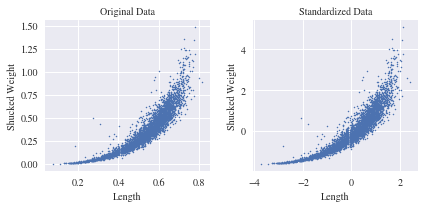

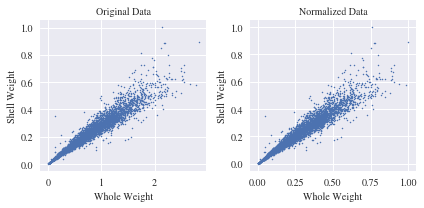

In [61]:
# Abalone plots
norm_abalone = normalize(abalone_sub)
plot(
    data=abalone_sub, 
    x_col_ind=0,
    y_col_ind=4,
    cols=abalone_columns_sub,
    filename="normalized_abalone.svg",
    scale_type="stand"
)

plot(
    data=abalone_sub, 
    x_col_ind=3,
    y_col_ind=6,
    cols=abalone_columns_sub,
    filename="standardized_abalone.svg",
    scale_type="norm"
)

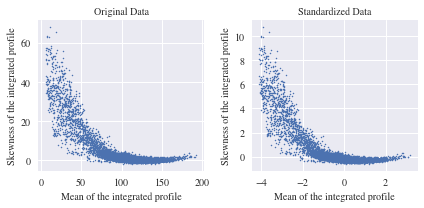

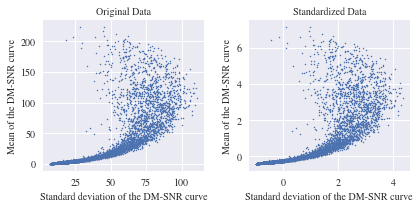

In [62]:
# Pulsar plots
plot(
    data=pulsar, 
    x_col_ind=0,
    y_col_ind=3,
    cols=pulsar_columns,
    filename="standardized_pulsar_1.pdf",
    scale_type="stand"
)
plot(
    data=pulsar, 
    x_col_ind=5,
    y_col_ind=4,
    cols=pulsar_columns,
    filename="standardized_pulsar_2.pdf",
    scale_type="stand"
)

## Missing Data

In [63]:
def impute_mode(data):
    print(data)

In [64]:
counts = []
for i in range(len(mushroom_columns)):
    count = np.sum(mushroom[:, i] == '?')
    count > 0 and print(f'Feature {i}: {count} missing value(s)')

missing_values = mushroom[np.argwhere(mushroom == '?')]

total_missing = (mushroom == '?').sum()

print(f'Total missing values: {total_missing}')

# Remove!

Feature 11: 2480 missing value(s)
Total missing values: 2480


### Pulsar EDA

In [ ]:
# import pandas as pd
# df = pd.DataFrame(normalize(pulsar))

# g = sns.PairGrid(df, vars=list(range(9)), hue=8, palette='RdBu_r')
# g.map(plt.scatter, alpha=0.8)
# g.add_legend()

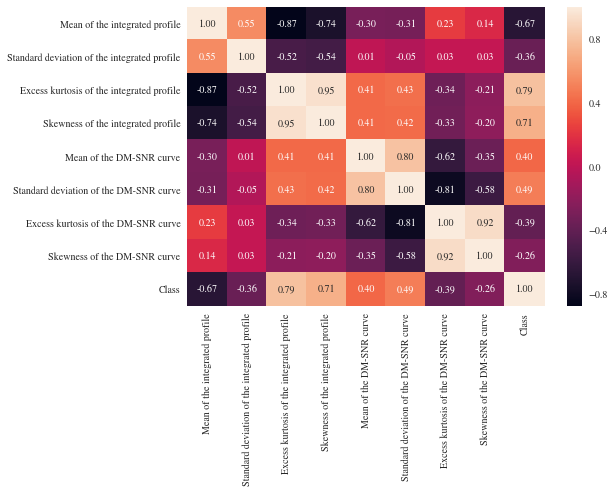

In [66]:

# # Create pandas dataframe and set column names
# df = pd.DataFrame(pulsar)
# df.columns = pulsar_columns

# # Obtain correlation matrix and plot on heatmap
# corr = df.corr()
# ax = sns.heatmap(corr, annot = True, fmt='.2f')
# ax.set_ylim(9.0, 0)

# # Save to file
# fig = ax.get_figure()
# fig.savefig('corr.pdf', dpi=400, bbox_inches='tight')

## Principal Component Analysis (PCA)

In [16]:
# Import dependencies
from scipy import linalg

In [17]:
class PCA:
    def __init__(self, n_components):
        self._n_components = n_components
        
    def fit(self, data):
        self._data = data
        
        eig_vectors, eig_vals = self._calc_eig_vects_vals(data[:, :-1])
        
        self.proj_matrix = self._calc_proj_matrix(eig_vectors)
        
        self._calc_explained_variance()
            
    def scree_plot(self, save=False):
        # The percentage of the variance explained by each principal component (PC)
        self._calc_explained_variance()
        plt.figure(figsize=(6, 4))

        labels = [i for i in range(1, self._n_components+1)]
        
        variances = [var for var in self.explained_variance[0:self._n_components]]
        variances = np.round(variances, 1)
        
        plt.bar(labels, variances, tick_label=labels)
        plt.plot(labels, variances, c='black', marker='o', markersize=3)
        
        for i, v in enumerate(variances):
            plt.annotate(str(v)+'%', (labels[i], v+0.5))
        
        plt.title("Scree Plot")
        plt.xlabel("Principal Component")
        plt.ylabel("Variance Explained (%)")
        
        if save:
            plt.savefig("PCAScreePlot.pdf", dpi=300)
            
    def _centralize(self, data):
        """ Centralizes a numpy matrix by subtracting each value by the mean of each column.

        Parameters:
            data (numpy.ndarray): The data to centralize.

        Returns:
            numpy.ndarray: The centralized numpy array.   

        """
        mus = np.mean(data, axis=0)
        return data - mus
        
    def _calc_eig_vects_vals(self, data):        
        # Centralize each feature separately        
        self.centralized = self._centralize(normalize(data))
        
        # Calculate covariance matrix
        cov = np.cov(self.centralized, rowvar=False)

        # Calculate eigenvalues and eigenvectors of the covariance matrix
        eig_vals, eig_vectors = linalg.eig(cov)

        self.eig_vals, self.eig_vectors = eig_vals, eig_vectors
        self.eig_vals = np.real(self.eig_vals)
        
        # In order to proceed with the PCA algorithm, we need to order the eigenvectors according to the eigenvalues
        ordered_eig_vectors = np.empty(eig_vectors.shape)
        
        tmp = eig_vals.copy()

        max_value = float("-inf")
        max_value_pos = -1

        for i in range(len(eig_vectors)):

            max_value = float("-inf")
            max_value_pos = -1

            for n in range(len(eig_vectors)):
                if (tmp[n] > max_value):
                    max_value = tmp[n]
                    max_value_pos = n

            ordered_eig_vectors[:,i] = eig_vectors[:,max_value_pos]
            tmp[max_value_pos] = float("-inf")
            
        return (eig_vectors, eig_vals)
            
    def _calc_proj_matrix(self, eig_vectors):
        # Finally, calculate projection matrix using the top k eigenvectors
        k = 2
        projection_matrix = eig_vectors[:, 0:k]
        return projection_matrix
    
    def get_corr_coef(self):
        return np.corrcoef(self.centralized, rowvar=False)
    
    def _calc_explained_variance(self):
        self.explained_variance = [(eig_val/sum(self.eig_vals)) * 100 for eig_val in self.eig_vals]
        
    def plot(self, data, save=False):
        # With the projection matrix P, we only need to calculate Y = X×P, where X is the centralized data, and Y is the transformed data with only k features
        pca_by_hand_data = data.dot(self.proj_matrix)

        plt.figure(figsize = (6,4))
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2',)
        plt.title('2 component PCA')
        targets = [(0, "Not Pulsar Star"), (1, "Pulsar Star")]
        colors = ["#3498db", "#ec7941"]
        
        labels = self._data[:, 8]
        
        for target, color in zip(targets,colors):
            indicesToKeep = np.where(labels == target[0])
            plt.scatter(pca_by_hand_data[indicesToKeep,0], pca_by_hand_data[indicesToKeep,1], c = color, s = 3)
        
        text_labs = [t[1] for t in targets]
        plt.legend(text_labs)
        
        if save:
            plt.savefig("PCAByHandData.pdf", dpi=300)

In [ ]:
# Instantiate PCA class and fit to pulsar data
pca = PCA(n_components=8)
pca.fit(pulsar)

# Obtain centralized data
centralized_data = pca.centralized

# Plot principal components with most of the variance
pca.plot(centralized_data, save=True)

# Plot explained variance
pca.scree_plot(save=True)

# Visualise and analyse correlation between features
# pca.get_corr_coef()

## PCA with Libraries

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(standardize(pulsar))

transformed = pca.transform(standardize(pulsar))

plt.plot(transformed[:, 0], transformed[:, 1], '.', markersize = 5)
plt.show()

## Linear Discriminant Analaysis (LDA)

In [18]:
from scipy import linalg

In [ ]:
def load_iris(filename):
    # Label encoding
    labels_dict = {
        'Iris-setosa': 0,
        'Iris-versicolor': 1,
        'Iris-virginica': 2
    }

    data = []
    labels = []

    with open(filename, 'r') as f:
        while True:
            line = f.readline().rstrip() 
            if len(line) == 0:
                break

            read_data = line.split(",") 

            data.append(read_data[0:4])

            txt_label = read_data[4]
            
            if txt_label in labels_dict:
                label = labels_dict[txt_label]
                labels.append(label)
            else:
                print(f"Unknown label found: '{txt_label}'")
                break

    data = np.array(data).astype(float)
    labels = np.array(labels)

    return data, labels

In [ ]:
class LDA:
    """ An implementation of Linear Discriminant Analysis (LDA) for dimensionality reduction and classification """
    def __init__(self):
        pass
    
    def _mean_features(self, data):
        """ 
        Calculates mean of each feature in the data matrix .

        Parameters:
            data: a numpy array of data items
        """
        return np.mean(data, axis=0)
    
    def _get_train_test_sets(self, data, labels):
        """ 
        Divides the input data matrix into training and testing sets (including labels).
        
        Parameters:
            data: a numpy array of data items
            labels: a numpy array of labels corresponding to the data items
        
        Returns:
            the new data matrix, the training data and labels, and the test data 
        """
        data = data[0:100, :]
        labels = labels[0:100]

        test_group_1 = np.random.choice(np.arange(50), size=5, replace=False)
        test_group_2 = np.random.choice(np.arange(50,100), size=5, replace=False)

        test_items = np.concatenate([test_group_1, test_group_2], axis=None)
        test_data = data[test_items,:]

        training_data = np.delete(data, test_items, axis=0)
        training_labels = np.delete(labels, test_items, axis=0)
        
        return data, training_data, training_labels, test_data
    
    def train(self, data, labels):
        """ 
        Trains the LDA classifier with the provided data and labels.
        
        Parameters:
            data: a numpy array of data items
            labels: a numpy array of labels corresponding to the data items        
        """
        # Get training and testing data
        self._data, self._training_data, self._training_labels, self._test_data = self._get_train_test_sets(data, labels)

        # Compute mean of all features
        means = np.zeros((2, self._training_data.shape[1]))

        means[0, :] = self._mean_features(self._training_data[0:45, :])
        means[1, :] = self._mean_features(self._training_data[45:90, :])

        # Obtain overall mean for scatter matrices
        self._overall_mean = self._mean_features(self._training_data)

        # Calculate within class scatter matrix
        SW = np.zeros((self._training_data.shape[1], self._training_data.shape[1]))

        # First class
        for p in range(0,45):
            diff = (self._training_data[p,:] - means[0,:]).reshape(self._training_data.shape[1], 1)
            SW += diff.dot(diff.T)

        # Second class
        for p in range(45,90):
            diff = (self._training_data[p,:] - means[1,:]).reshape(self._training_data.shape[1], 1)
            SW += diff.dot(diff.T)

        # Calculate between-class scatter matrix
        SB = np.zeros((data.shape[1], data.shape[1]))

        for c in range(2):
            diff = (means[c,:] - self._overall_mean).reshape(self._training_data.shape[1],1)
            SB += 45 * diff.dot(diff.T)

        # Compute eigenvalues and eigenvectors
        invSW = np.linalg.pinv(SW)
        eig_vals, eig_vectors = linalg.eig(invSW.dot(SB))
        
        # Order eigenvectors (each column) by eigenvalues in descending order
        eig_val_inds = np.flip(eig_vals.copy().argsort())
        self._ordered_eig_vectors = eig_vectors[:, eig_val_inds]
        
        # Find top k eigenvectors (set k to 2 so we can visualise in 2D)
        k = 2
        projection_mat = self._ordered_eig_vectors[:, 0:k]
        
        # Step 6: project dataset and plot results
        self._lda_data = self._training_data.dot(projection_mat)
        self._test_LDA = self._test_data.dot(projection_mat)

    def plot(self):    
        """ Plots the results of LDA using the projection matrix for the training and testing data. """

        # Plot first 2 principal components in projected LDA space
        plt.figure(figsize=(6,4))
        plt.title("Training and testing data in projected LDA space")

        plt.plot(self._lda_data[0:45,0], self._lda_data[0:45,1], "r.")
        plt.plot(self._lda_data[45:90,0], self._lda_data[45:90,1], "g.")

        plt.plot(self._test_LDA[0:5,0], self._test_LDA[0:5,1], "rx")
        plt.plot(self._test_LDA[5:10,0], self._test_LDA[5:10,1], "gx")

        plt.xlabel("1st Principal Component")
        plt.ylabel("2nd Principal Component")

        plt.savefig("lda.png", dpi=300)

        plt.show()
        plt.close()

        # Classification - plot results in 1D space
        k = 1
        projection_mat = self._ordered_eig_vectors[:,0:k]

        lda_data = self._training_data.dot(projection_mat)
        test_LDA = self._test_data.dot(projection_mat)
        threshold = self._overall_mean.dot(projection_mat)

        plt.figure(figsize=(6,4))
        plt.title("LDA result in 1D space")

        plt.plot(lda_data[0:45,0], np.zeros(45), "r.")
        plt.plot(lda_data[45:90,0], np.zeros(45), "g.")

        plt.plot(test_LDA[0:5,0], np.zeros(5), "rx", markersize=12)
        plt.plot(test_LDA[5:10,0], np.zeros(5), "gx", markersize=12)

        plt.plot(threshold, 0, "o")

        plt.xlabel("1st Principal Component")

        plt.savefig("lda1D.png", dpi=300)

        plt.show()
        plt.close()

In [ ]:
# Load data
data, labels = load_iris("iris.csv")

# Initialise new LDA instance
lda = LDA()

# Train classifier
lda.train(data, labels)

# Plot results
lda.plot()

In [ ]:
def load_abalone(filename):
    # Label encoding
    labels_dict = {
        'negative': 0,
        'positive': 1
    }

    data = []
    labels = []

    with open(filename, 'r') as f:
        while True:
            line = f.readline().rstrip()
            if len(line) == 0:
                break

            read_data = line.split(",")
            read_data = [x.replace(' ', '') for x in read_data]
                        
            sex = None
            
            if sex == 'M':
                sex = [1, 0, 0]
            elif sex == 'F':
                sex = [0, 1, 0]
            else:
                sex = [0, 0, 1]
                
            feature_vals = sex + read_data[1:8]
            data.append(feature_vals)
            
            txt_label = read_data[8].rstrip()
                
            if txt_label in labels_dict:
                label = labels_dict[txt_label]
                labels.append(label)
            else:
                print(f"Unknown label found: '{txt_label}'")
                break

    data = np.array(data).astype(float)
    labels = np.array(labels)
    
    return data, labels

In [ ]:
# Load data
data, labels = load_abalone("../Data/Abalone/abalone19.csv")

# Initialise new LDA instance
lda = LDA()

# Train classifier
lda.train(data, labels)

# Plot results
lda.plot()

In [ ]:
def dist(p1, p2):
    """ Calculates the distance between 2 points p1 and p2 """
    total = 0

    for p1, p2 in zip(p1, p2):
        total += (p1 - p2) ** 2

    return total ** 0.5

## Handling Imbalanced Classes

In [ ]:
# Import dependencies
import random

In [ ]:
def get_num_labels(labels, l):
    """
    Obtains the number of class labels l in the provided labels list.
    
    Parameters:
        labels: a numpy array of class labels
        l: the class label to search for
    
    Returns:
        the number of class labels l
    """
    return len(np.where(labels == l)[0])

In [32]:
def get_label_counts(labels):
    """
    Obtains the counts of unique labels in a list of labels.
    
    Parameters:
        labels: a numpy array of labels
    
    Returns:
        the counts for each label
    """
    return np.array(np.unique(labels, return_counts=True)).T

In [33]:
def get_minority_class(labels):
    """
    Obtains the minority class labels based on a list of labels.
    
    Parameters:
        labels: a numpy array of class labels

    Returns:
        the minority class label
    """
    # Get unique class labels
    unique_labels = np.unique(labels)
    
    minority_class = float("inf")
    
    # Find minority class
    for label in unique_labels:
        label_inds = np.where(labels == label)[0]
        if len(label_inds) < minority_class:
            minority_class = label
    
    return minority_class

In [34]:
class Sampler:
    """ Sampling class which provides sampling methods for undersampling, oversampling and SMOTE """
    
    def over_sample(self, data, labels, auto=False, k=2, l=0): 
        """ 
        Uses the oversampling technique on the provided dataset to oversample the provided class l.

        Parameters:
            data: a numpy array of data items to oversample
            labels: a numpy array of labels corresponding to data items in the data array
            auto: True if the minority class to oversample is to be found, False otherwise
            k: the number of new items to generate with the label l
            l: the label to oversample

        Returns:
            a new numpy array containing the original data and the oversampled classes
        """
        new_data = data.copy()
        new_labels = labels.copy()
        
        # Automatically detect minority class to oversample
        if auto:
            values, counts = np.unique(labels, return_counts=True)
            ind = np.bincount(labels).argmin()
            num_minority = counts[ind]
            k = counts[int(not ind)] - num_minority
            l = ind

        # Find all indices with label l
        label_l_positions = [i for i in range(len(labels)) if labels[i] == l]

        # Error checking
        if len(label_l_positions) == 0:
            return f"No items with label {l} present to oversample"
        elif k <= 0:
            return "Error - enter a value of k greater than 0"

        # Select k indices to duplicate (with replacement)
        for _ in range(k): 
            item_ind = label_l_positions[random.randint(0, len(label_l_positions)-1)] 
            new_data = np.vstack((new_data, data[item_ind]))
            new_labels = np.append(new_labels, l)

        return new_data, new_labels
    
    def under_sample(self, data, labels, auto=False, k=2, l=0): 
        """ 
        Uses the undersampling technique on the provided dataset to undersample the provided class l.

        Parameters:
            data: a numpy array of data items to undersample
            labels: a numpy array of labels corresponding to data items in the data array
            auto: True if the majority class to undersample is to be found, False otherwise
            k: the number of items to eliminate with the label l
            l: the label to undersample

        Returns:
            a numpy array containing the original data with the undersampled classes, and a numpy array of undersampled labels
        """
        new_data = np.array([])
        new_labels = np.array([])
        
        # Automatically detect majority class to undersample
        if auto:
            values, counts = np.unique(labels, return_counts=True)
            ind = np.bincount(labels).argmax()
            num_majority = counts[ind]
            k = num_majority - counts[int(not ind)]
            l = ind

        # Find all indices with label l
        label_l_positions = [i for i in range(len(labels)) if labels[i] == l]

        # Error checking
        num_labels = len(label_l_positions)
        if k > num_labels:
            print(f"Error - k={k} > {num_labels} items with label {l}, so removing {num_labels} items with label {l}")
            k = num_labels
        elif k <= 0:
            return "Error - enter a value of k greater than 0"

        # Select k indices to delete
        to_delete = random.sample(label_l_positions, k)

        # Keep original data unless present in to_delete list
        for i in range(len(data)):
            if (i not in to_delete):
                if (len(new_data) != 0):
                    new_data = np.vstack((new_data, data[i, :]))
                    new_labels = np.vstack((new_labels, labels[i]))
                else:
                    new_data = data[i, :].copy() 
                    new_labels = labels[i]

        return new_data, new_labels
        
    def smote(self, data, labels, label, k_neighbours=2, iterations=3):
        """ An implementation of Synthetic Minority Oversampling Technique (SMOTE) """
        new_data = data.copy()
        new_labels = labels.copy()
                
        # Find all indices with label l
        label_l_positions = [i for i in range(len(labels)) if labels[i] == label]

        for _ in range(iterations):
            # Randomly choose an item with label l 
            item_i = label_l_positions[random.randint(0, len(label_l_positions)-1)]
            
            # Get the K nearest neighbours
            dists = [] 
            dist_inds = []

            for item in label_l_positions: 
                if (item != item_i):
                    dists.append(dist(data[item], data[item_i])) 
                    dist_inds.append(item)

            k_neighbours_list = []

            for n in range(k_neighbours):
                nearest = np.argmin(dists) 
                k_neighbours_list.append(dist_inds[nearest]) 
                dists[nearest] = float("inf")

            # Randomly choose one of the k neighbours
            item_j = k_neighbours_list[random.randint(0, len(k_neighbours_list)-1)]

            # Get the vector between the two points (assuming only position 0 and 1 are features and 2 is the label)
#             x0 = data[item_j, 0] - data[item_i, 0]
#             x1 = data[item_j, 1] - data[item_i, 1]
            
            alpha = random.random()
            new_point = []
            
            for i in range(data.shape[1]):
                xi = data[item_j, i] - data[item_i, i]
                new_point.append(data[item_i, i] + alpha*xi)
            
            
#             new_point = [data[item_i, 0] + alpha*x0, data[item_i, 1] + alpha*x1]

            new_data = np.vstack((new_data, new_point))        
            new_labels = np.append(new_labels, labels[item_i])
        
#             new_labels = np.vstack((new_labels, labels[item_i]))
            
        return new_data, new_labels

In [35]:
# For abalone data
# Obtain minority class from labels
labels = abalone[:, -1]

minority_class = get_minority_class(labels)

label_counts = get_label_counts(labels)
print(f"[Before sampling]\n{label_counts}")

sampler = Sampler()

### 
# Oversampling
###
no_to_oversample = 4000
label_to_oversample = 1
os_abalone_data, os_abalone_labels = sampler.over_sample(abalone, labels, k=no_to_oversample, l=label_to_oversample)

label_counts = get_label_counts(os_abalone_labels)
print(f"[After oversampling {no_to_oversample} label {label_to_oversample} items]\n{label_counts}")

# Automatic detection and oversampling of minority class 
os_abalone_data, os_abalone_labels = sampler.over_sample(abalone, labels, auto=True)

label_counts = get_label_counts(os_abalone_labels)
print(f"[After automatic oversampling]\n{label_counts}")

### 
# Undersampling
###
no_to_undersample = 2500
label_to_undersample = 0
us_abalone_data, us_abalone_labels = sampler.under_sample(abalone, labels, k=no_to_undersample, l=label_to_undersample)

label_counts = get_label_counts(us_abalone_labels)
print(f"[After undersampling {no_to_undersample} label {label_to_undersample} items]\n{label_counts}")

# Automatic detection and oversampling of minority class 
us_abalone_data, us_abalone_labels = sampler.under_sample(abalone, labels, auto=True)

label_counts = get_label_counts(us_abalone_labels)
print(f"[After automatic undersampling]\n{label_counts}")

[Before sampling]
[[0.000e+00 4.142e+03]
 [1.000e+00 3.200e+01]]


NameError: name 'data' is not defined

In [ ]:
import math

In [ ]:
# Create new Sampler instance to use SMOTE on abalone data
sampler = Sampler()

no_to_oversample = 10
label_to_oversample = 1

smote_abalone_data, smote_abalone_labels = sampler.smote(
    data=data,
    labels=labels,
    label=label_to_oversample,
    k_neighbours=2, 
    iterations=no_to_oversample
)

label_counts = get_label_counts(smote_abalone_labels)
print(f"[After SMOTE oversampling with {no_to_oversample} label {label_to_oversample} items]\n{label_counts}")

## Outliers

In [ ]:
def find_outliers(data):
    # Standardize - calculate Z-score
    stand = standardize(data)
    
    # Values less than -3 or greater than 3 are considered outliers
    row_inds, col_inds = np.where((stand < -3) | (stand > 3))

    num_outliers = row_inds.shape[0]
    print(f"[Found {num_outliers} potential outliers]\n")

    for ind in range(num_outliers):
        row = row_inds[ind]
        col = col_inds[ind]
        print(f"Row {row}, column {col} --> {data[row][col]} (Z-score: {stand[row][col]})")

In [ ]:
# # Remove labels
# pulsar_sub = pulsar[:, 0:8]

# # Find outliers
# find_outliers(pulsar_sub)

# 2. Clustering

## 2.1 K-means Clustering

In [ ]:
# Import dependencies
import time
from itertools import cycle
cycol = cycle('rbgcmky')

In [ ]:
class Kmeans:
    """ K-means clustering implementation """
    
    def __init__(self, k=2, threshold=0.1):
        """ 
        Initialises a new Kmeans instance.
        
        Parameters:
            k: the specified number of clusters
            threshold: the minimum distance below which the distance between centroids will be compared to
        """
        self._k = k
        self._threshold = threshold
        
    def fit(self, data):
        """ 
        Performs K-means clustering on the provided data. 
        
        Parameters:
            data: a numpy array of numerical values
        
        Returns:
            the final computed centroids
        """
        self._data = data
        
        # Standardise the data         
        standardized_data = standardize(data)
    
        # Initialise centroids randomly
        centroids = np.random.random((self._k, columns))

        # Scale the random numbers using min and max of each feature as ranges for random sampling
        columns = 2
        for i in range(columns):
            max_val = standardized_data[:, i].max()
            min_val = standardized_data[:, i].min()

            for c in range(self._k):
                centroids[c,i] = min_val + centroids[c,i] * (max_val - min_val)

        old_centroids = np.zeros(centroids.shape)

        clusters = np.zeros(len(standardized_data))

        # Stores the sum of all distances between the centroids of the current and previous iteration
        dist_centroids = float("inf")

        while dist_centroids > self._threshold:
            for i in range(len(standardized_data)):
                clusters[i] = self._min_dist_pos(standardized_data[i], centroids)

            old_centroids = centroids.copy()

            for i in range(self._k):
                points = np.array([])

                for j in range(len(data)):
                    if (clusters[j] == i):
                        if (len(points) == 0):
                            points = standardized_data[j,:].copy()
                        else:
                            points = np.vstack((points, standardized_data[j,:]))

                centroids[i] = np.mean(points, axis=0)

            dist_centroids = self._sum_dist(centroids, old_centroids)


        self._centroids = centroids
        self._groups = None

        # Append cluster number to each observation in standardized data
        for d in standardized_data:
            cluster_no = self._min_dist_pos(d, self._centroids)
            d = np.append(d, cluster_no)
            if self._groups is None:
                self._groups = np.array([d])
            else:
                self._groups = np.vstack((self._groups, d))
                        
    def _dist(self, p1, p2):
        """ Calculates the distance between 2 points p1 and p2 """
        total = 0

        for p1, p2 in zip(p1, p2):
            total += (p1 - p2) ** 2

        return total ** 0.5

    def _min_dist_pos(self, point, mat):
        """ Finds the position of the minimum distance between a point and a set of points (mat) """
        min_val = float("inf")
        min_pos = -1
        
        # Each row in mat is a point
        # Calculate distance between all points and point parameter
        for row_ind in range(len(mat)):
            d = self._dist(point, mat[row_ind, :])

            if (d < min_val):
                min_val = d
                min_pos = row_ind

        return min_pos

    def _sum_dist(self, mat1, mat2):
        """ Returns the sum across the distances between each row of mat1 and mat2 """
        total = 0

        for pos in range(len(mat1)):
            total += self._dist(mat1[pos, :], mat2[pos, :])

        return total
    
    def plot(self):
        """ Plots the clusters found """
        plt.figure(figsize=(9,6))
        
        plt.title(f"K-means clustering with {self._k} clusters")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        
        cycol = cycle('bgrcmk')

        # Plot points belonging to clusters
        for i in range(self._k):
            cluster_i_inds = self._groups[self._groups[:, 2] == i]
            plt.plot(cluster_i_inds[:, 0], cluster_i_inds[:, 1], next(cycol)+'.')
        
        # Plot cluster centres
        for i in range(self._k):
            plt.plot(self._centroids[i, 0], self._centroids[i, 1], 'wx', markersize=10)

        plt.savefig(f"kmeans_{self._k}clusters.pdf")
        plt.show()
        plt.close()
        
    def plot_k(self, k):
        """ Method to plot k-means results for k clusters in separate plots """
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(12,9))
        axes = [ax1, ax2, ax3, ax4, ax5, ax6]
        
        for i in range(2, k+1):
            kmeans = KMeans(i)
            kmeans.fit(self._data)
            
            cycol = cycle('bgrcmk')

            # Plot points belonging to clusters
            for j in range(kmeans._k):
                cluster_i_inds = kmeans._groups[kmeans._groups[:, 2] == j]
                axes[i-2].plot(cluster_i_inds[:, 0], cluster_i_inds[:, 1], next(cycol)+'.')

            # Plot cluster centres
            for j in range(kmeans._k):
                axes[i-2].plot(kmeans._centroids[j, 0], kmeans._centroids[j, 1], 'wx')
                
            axes[i-2].set_title(f'K-means clustering with {i} clusters')
            axes[i-2].set_xlabel('Feature 1')
            axes[i-2].set_ylabel('Feature 2')
            
        plt.show()

### Pulsar K-means

#### With Preprocessing

In [ ]:
# We know we need 2 clusters for k-means (either pulsar or not pulsar)

# Store class labels in separate variable
pulsar_nolbl = pulsar[:, :-1]
pulsar_labels = pulsar[:, -1]

# Get training and testing split
train_X, train_Y, test = train_test_split(pulsar, pulsar_labels)

test_X = pulsar[test, :-1]
test_Y = pulsar[test, -1]

# K-means for train and evaluate on test
km = KMeans(k=2)
km.fit(train_X[:, 0:2])
km.plot()
# Y_preds = km.predict(test_X)



print(pulsar_nolbl)

#### With Custom Features

In [ ]:
# Load Data
data = open_csv("../Data/HTRU2/HTRU_2.csv")

# Reduce number of columns
reduced_data = data[:, 0:2].astype(float)

# Perform K-means clustering
start = time.time()
k = 2

print(f"Running k-means clustering with {k} clusters...")

# K-means
kmeans = KMeans(k=k, threshold=0.001)
kmeans.fit(reduced_data)
kmeans.plot()

print(f'Completed in {(time.time() - start)}s')

In [ ]:
# Perform K-means clustering
start = time.time()
max_no_k = 7

print(f"Generating plot of k-means clustering for clusters 2-{max_no_k}...")

# K-means
kmeans = KMeans(k=max_no_k, threshold=0.00001)
kmeans.fit(reduced_data)
kmeans.plot_k(max_no_k)

print(f'Completed in {(time.time() - start)}s')

## 2.2 Agglomerative Hierarchical Clustering

In [ ]:
import scipy.cluster as sc
import scipy.spatial.distance as sd
import math

In [ ]:
def distance(data):

    rows = data.shape[0]
    cols = data.shape[1]
    
    distanceMatrix = np.zeros((rows, rows))

    for i in range(rows):
        for j in range(rows):

            sumTotal = 0

            for c in range(cols):

                sumTotal = sumTotal + pow((data[i,c] - data[j,c]),2)

            distanceMatrix[i,j] = math.sqrt(sumTotal)

    return distanceMatrix

In [ ]:
data = np.array([[1,2],
                [2.5, 4.5],
                [2,2],
                [4,1.5],
                [4,2.5]])

distanceData = distance(data)

condensedDistance = sd.squareform(distanceData)

Z = sc.hierarchy.linkage(condensedDistance)

plt.figure(figsize=(6,4))

sc.hierarchy.dendrogram(Z)

plt.savefig("dendrogram.pdf")

plt.close()

# Exercise 2: Weather data dendrogram
## Load Data
dataRaw = [];
DataFile = open("../Clustering/ClimateData.csv", "r")

while True:
    theline = DataFile.readline()
    if len(theline) == 0:
         break  
    readData = theline.split(",")
    for pos in range(len(readData)):
        readData[pos] = float(readData[pos]);
    dataRaw.append(readData)

DataFile.close()

data = np.array(dataRaw)

distanceData = distance(data)

condensedDistance = sd.squareform(distanceData)

Z = sc.hierarchy.linkage(condensedDistance)

plt.figure(figsize=(6,4))
#plt.figure(figsize=(300,100))

sc.hierarchy.dendrogram(Z)

# plt.savefig("dendrogramWeatherSmall.pdf")

plt.close()

# Last 10:

plt.figure(figsize=(6,4))

sc.hierarchy.dendrogram(Z, truncate_mode="lastp",p=10)

plt.savefig("dendrogramWeatherLast10.pdf")

plt.close()

plt.figure(figsize=(6,4))

sc.hierarchy.dendrogram(Z, truncate_mode="lastp",p=12)

plt.savefig("dendrogramWeatherLast12.pdf")

plt.close()

plt.figure(figsize=(6,4))

sc.hierarchy.dendrogram(Z, truncate_mode="level",p=4)

plt.savefig("dendrogramWeatherLevel4.pdf")

plt.close()

## 2.3 Algorithm 3

## 2.4 DBSCAN (Density-based spatial clustering of applications with noise)

# 3. Classification

In [ ]:
# Import dependencies
from sklearn.metrics import roc_curve, auc

### Evaluation Metrics

In [ ]:
class ClassificationEvaluator:
    """ Class to evaluate the performance of an ML model given the predicted and actual labels """
    
    def __init__(self, pred_labels, actual_labels):
        """
        Initialise the predicted and actual labels the evaluator will work with.
        
        Parameters:
            pred_labels: a numpy array of predicted class labels
            actual_labels: a numpy array of actual class labels
        """
        self._pred_labels = pred_labels
        self._actual_labels = actual_labels
    
    def _accuracy(self):        
        """
        Computes the accuracy of the classifier.
        Accuracy = (TP + TN) / (TP + TN + FP + FN)
        
        Returns:
            the accuracy of the classifier
        """
        total = self._TP + self._TN + self._FP + self._FN
        return (self._TP + self._TN) / total if total != 0 else 0
    
    def _precision(self):
        """
        Computes the precision of the classifier.
        How many predicted positives were correct?
        Precision = TP / (TP + FP)
        
        Returns:
            the precision of the classifier
        """
        return self._TP / (self._TP + self._FP) if self._TP + self._FP != 0 else 0
        
    def _recall(self):
        """
        Computes the recall of the classifier.
        How many actual positives were predicted correctly?
        Recall = TP / (TP + FN)
        
        Returns:
            the recall of the classifier
        """
        return (self._TP / (self._TP + self._FN)) if self._TP + self._FN != 0 else 0
    
    def _tp(self):
        """
        Computes the number of true positives based on the predicted and actual labels.
        Number of outcomes where the model correctly predicts the positive class.
        
        Returns:
            the number of true positives
        """
        return np.logical_and(self._pred_labels == 1, self._actual_labels == 1).sum()
    
    def _tn(self):
        """
        Computes the number of true negatives based on the predicted and actual labels.
        Number of outcomes where the model correctly predicts the negative class.
        
        Returns:
            the number of true negatives
        """
        return np.logical_and(self._pred_labels == 0, self._actual_labels == 0).sum()
    
    def _fp(self):
        """
        Computes the number of false positives based on the predicted and actual labels.
        Number of outcomes where the model incorrectly predicts the positive class.
        
        Returns:
            the number of false positives
        """
        return np.logical_and(self._pred_labels == 1, self._actual_labels == 0).sum()
    
    def _fn(self):
        """
        Computes the number of false negatives based on the predicted and actual labels.
        Number of outcomes where the model incorrectly predicts the negative class.
        
        Returns:
            the number of false negatives
        """
        return np.logical_and(self._pred_labels == 0, self._actual_labels == 1).sum()
    
    def _tpr(self):
        """
        Computes the true positive rate (i.e. recall).
        TPR = TP / (TP + FN)
        
        Returns:
            the true positive rate
        """
        return self._recall()
    
    def _fpr(self):
        """
        Computes the false positive rate.
        FPR = FP / (FP + TN)
        
        Returns:
            the false positive rate
        """
        return self._FP / (self._FP + self._TN) if self._FP + self._TN != 0 else 0

    def evaluate(self):
        """
        Method to compute the accuracy, precision, recall and F1 score metrics for this classifier (to 4.d.p).
        
        Returns:
            a dictionary containing the accuracy, precision, recall and F1 metrics, and the confusion matrix
        """        
        self._TP = self._tp()
        self._TN = self._tn()
        self._FP = self._fp()
        self._FN = self._fn()
        
        acc = round(self._accuracy(), 4)
        prec = round(self._precision(), 4)
        rec = round(self._recall(), 4)
        f1 = round(2 * ((prec * rec) / (prec + rec)), 4) if prec + rec != 0 else 0
        
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'cm': {
                'tp': self._TP,
                'tn': self._TN,
                'fp': self._FP,
                'fn': self._FN,
            }
        }
    
    def plot_roc(self):

        test = np.array([0, 1, 0, 0, 1, 0])
        pred = np.array([0.1, 1, 0.9, 0.6, 0.85, 0.2])

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(test, pred)
            roc_auc[i] = auc(fpr[i], tpr[i])

        print(roc_auc_score(test, pred))
        plt.figure()
        plt.plot(fpr[1], tpr[1])
        plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.show()

In [ ]:
pred_labels = np.array(  [1, 0, 1, 1, 0, 1, 0, 1, 1, 1])
actual_labels = np.array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0])

evaluator = ClassificationEvaluator(pred_labels, actual_labels)
metrics = evaluator.evaluate()
evaluator.plot_roc()

print(metrics)

## 3.1 Radial Basis Function Neural Network (RBF)

In [ ]:
import numpy as np
import math
from scipy.linalg import pinv

In [ ]:
class RBFNN:
    """ An implementation of a Radial Basis Function Neural Network """
    
    def __init__(self, n_prototypes=4, n_classes=2):
        """ Constructor to initialise the number of prototypes and the number of classes used in the dataset """
        self._n_prototypes = n_prototypes
        self._n_classes = n_classes
        
    def _dist(self, p1, p2):
        """ 
        Calculates the distance between 2 points p1 and p2.
        
        Parameters:
            p1: a numpy array containing the first point values
            p2: a numpy array containing the second point values
        """
        total = 0

        for p1, p2 in zip(p1, p2):
            total += (p1 - p2) ** 2

        return total ** 0.5
    
    def _max_dist(self, m1, m2):
        """ 
        Computes the maximum distance between the provided matrices.
        
        Parameters:
            m1: the first matrix of values
            m2: the second matrix of values
        Returns:
            the maximum distance between the provided matrices
        """
        max_distance = -1

        for i in range(len(m1)):
            for j in range(len(m2)):            
                distance = self._dist(m1[i,:], m2[j,:])

                if (distance > max_distance):
                    max_distance = distance

        return max_distance
    
    def _predict(self, item):
        """
        Predicts the class label for the provided item.
        
        Parameters:
            item: a numpy array of data values
        Returns:
            the predicted class
        """
        out = []

        ## Hidden layer
        for proto in self._prototypes:
            distance = self._dist(item, proto)
            neuron_out = np.exp(-(distance)/self._sigma**2)
            out.append(neuron_out)

        net_out = []
        for c in range(self._n_classes):
            result = np.dot(self._weights[:,c], out)
            net_out.append(result)

        return np.argmax(net_out)
        
    def train(self, data, labels):
        # Convert labels
        labels_new = []
        for label in labels:
            if (label== 0):
                labels_new.append([1,0])
            else:
                labels_new.append([0,1])

        # Generating prototypes - randomly select 4 items from each class to compose prototypes
        num_rows = data.shape[0]
        half = math.floor(num_rows/2)
        group1 = np.random.randint(0, half, size=self._n_prototypes)
        group2 = np.random.randint(half, num_rows, size=self._n_prototypes)

        self._prototypes = np.vstack([data[group1,:], data[group2,:]])

        # Compute sigma
        distance = self._max_dist(self._prototypes, self._prototypes)
        self._sigma = distance/(self._n_prototypes * self._n_classes) ** 0.5

        # For each item in training set, get the output
        output = np.zeros(shape=(num_rows, self._n_prototypes * self._n_classes))

        for item in range(num_rows):
            out = []

            for proto in self._prototypes:
                distance = self._dist(data[item], proto)
                neuron_out = np.exp(-distance/self._sigma**2)
                out.append(neuron_out)

            output[item,:] = np.array(out)

        # Use pseudo-inverse to calculate weights
        self._weights = np.dot(pinv(output), labels_new)
        
    def test(self, data, test_data, verbose=False):
        # Testing
        preds = [self._predict(data[item, :]) for item in test_data]
        preds = np.array(preds)

        acc = round((preds == labels[test_data]).mean() * 100, 5) 
        count = 0
        
        for i, item in enumerate(test_data):
            if verbose:
                print(f"Item: {item}")
                print(f"Predicted Class: {preds[i]}")
                print(f"True Class: {labels[item]} \n")
                
            count += labels[item] == preds[i]

        print(f"{count}/{len(test_data)} items predicted correctly ({acc}% accuracy)")

In [ ]:
# Create new RBF neural network for iris data
model = RBFNN()

# Load and normalize data
data, labels = load_iris("iris.csv")
data = normalize(data)

# Get random training and testing sets
train_X, train_Y, test = train_test_split(data, labels)

# Training
model.train(train_X, train_Y)

# Testing
model.test(data, test, verbose=True)

In [ ]:
# Create new RBF neural network for abalone
model = RBFNN()

# Load and normalize data
data, labels = load_abalone("../Data/Abalone/abalone19.csv")

norm_data_subset = normalize(data[:, 3:])
data = np.concatenate([data, norm_data_subset], axis=1)

# Get random training and testing sets
train_X, train_Y, test = train_test_split(data, labels)

# Training
model.train(train_X, train_Y)

# Testing
model.test(data, test, verbose=False)

## 3.2 Feedforward Neural Network

In [ ]:
# Import dependencies
import torch
import time

In [ ]:
class NeuralNetwork:
    """ An implementation of a Neural Network with a single hidden layer with customisable hyperparameters """
    
    def __init__(self, learning_rate=0.001, n_epochs=1000, n_hidden_units=3):
        """ 
        Initialises a new neural network instance with tunable hyperparameters.
        
        Parameters:
            learning_rate: the amount of a step to take on each iteration of gradient descent
            n_epochs: the number of training iterations
            n_hidden_units: the number of neurons in the hidden layer of the neural network
        """
        self._learning_rate = learning_rate
        self._n_epochs = n_epochs
        self._n_hidden_units = n_hidden_units
        
    def _convert_labels(self, labels):
        """
        Converts an array of labels to a unique set of 1's and 0's using label encoding.
        
        Parameters:
            labels: a numpy array of labels to convert
        
        Returns:
            a PyTorch tensor object of the converted labels
        """
        # Converting labels
        num_labels = len(np.unique(labels))
        conv_labels = []
        
        # Handle multi-class scenario
        if num_labels > 2:            
            for label in labels:
                unique_label = [0] * num_labels
                unique_label[label] = 1
                conv_labels.append(unique_label)
        else:
            for label in labels:
                if label == 0:
                    conv_labels.append([1, 0])
                else:
                    conv_labels.append([0, 1])

        # Converting numpy array to PyTorch tensor
        labels = torch.tensor(conv_labels, dtype=torch.float32) 
        return labels
    
    def _loss_fn(self):
        """ Returns the neural network's loss function """
        return torch.nn.MSELoss(reduction='sum')
    
    def _create_model(self, n_inputs, n_outputs):
        """
        Creates the neural network architecture with a number of inputs, outputs and a number of neurons in the hidden layer.
        
        Parameters:
            n_inputs: the number of neurons in the input layer
            n_outputs: the number of neurons in the output layer
        """
        return torch.nn.Sequential( 
            torch.nn.Linear(n_inputs, self._n_hidden_units),
            torch.nn.Sigmoid(),
            torch.nn.Linear(self._n_hidden_units, n_outputs),
            torch.nn.Sigmoid(),
        )
    
    def train(self, data, labels, verbose=False):
        """
        Trains the neural network with the provided data and labels.
        
        Parameters:
            data: a numpy array of data items to train
            labels: a numpy array of labels corresponding to items in the data array
            verbose: True if the loss on each training iteration is to be printed, False otherwise
            
        Returns:
            the trained model
        """
        # Convert labels and convert data to PyTorch tensor
        labels = self._convert_labels(labels)
        data = torch.from_numpy(data)

        n_inputs = data.shape[1]
        n_outputs = labels.shape[1]

        # Define model architecture
        model = self._create_model(n_inputs, n_outputs)

        # Loss function
        loss_fn = self._loss_fn()
    
        # Training loop
        for t in range(self._n_epochs):
            # Compute class predictions
            y_pred = model(data)
            
            # Compute loss
            loss = loss_fn(y_pred, labels) 

            if verbose:
                print(t,loss.item())

            # Backpropagation (compute gradients)
            model.zero_grad()
            loss.backward()

            # Update model parameters
            with torch.no_grad():
                for param in model.parameters():
                    param -= self._learning_rate * param.grad
                    
        return model 
    
    def test(self, model, test, data, labels, summary=False, verbose=False):
        """ 
        Tests the trained model with the provided test data and labels.
        
        Parameters:
            model: the trained PyTorch neural network model
            test: the test data to obtain class predictions for
            data: the full dataset
            labels: test labels corresponding to items in the test set
            summary: True if a summary of the test results are to be printed, False otherwise
            verbose: True if the predictions on each test iteration is to be printed, False otherwise
            
        Returns:
            a dictionary of number of correctly predicted items and model accuracy
        """
        correct = 0
        preds = []
    
        # Obtain predictions for each class
        for item in test: 
            with torch.no_grad():
                prediction = model(torch.from_numpy(data[item, :]))

            # Extract class prediction
            class_pred = prediction.argmax().item()
            correct += class_pred == labels[item]
            preds.append(class_pred)

            if verbose:
                print(f"Item: {item}")
                print(f"NN Output: {prediction}") 
                print(f"Predicted class: {class_pred}")
                print(f"True Class: {labels[item]}")

        # Compute accuracy
        acc = round(correct/len(test), 2) * 100
        
        preds = np.array(preds)
        
        metrics = ClassificationEvaluator(pred_labels=preds, actual_labels=labels[test]).evaluate()        
                
        if summary:
            print(f"Accuracy: {metrics['accuracy'] * 100}%")
            print(f"Precision: {metrics['precision'] * 100}%")
            print(f"Recall: {metrics['recall'] * 100}%")
            print(f"F1-score: {metrics['f1']}")
        
        return metrics

### Abalone Neural Network Classification

In [ ]:
# Load abalone data and labels
data, labels = load_abalone('../Data/Abalone/abalone19.csv')
data = data.astype(np.float32)

# Normalize numeric columns
norm_data = normalize(data[:, 3:])
data = np.column_stack((data[:, :3], norm_data))

# Create new neural network
nn = NeuralNetwork(
    learning_rate=0.001, 
    n_epochs=2000,
    n_hidden_units=3
)

# Get train and test sets
train_X, train_Y, test = train_test_split(
    data=data, 
    labels=labels,
    train_size=0.8
)

start = time.time()

# Train the model
model = nn.train(train_X, train_Y)

print(f'Time elapsed: {round(time.time() - start, 2)}s')

In [ ]:
# Test the model
test_results = nn.test(model, test, data, labels, summary=True)

### 3.2.1 Accuracy against parameters plot

In [ ]:
def test_nn(data, labels, train_size, learning_rate, n_epochs, n_hidden_units):
    # Create new neural network
    nn = NeuralNetwork(
        learning_rate=learning_rate, 
        n_epochs=n_epochs,
        n_hidden_units=n_hidden_units
    )

    # Get train and test sets
    train_X, train_Y, test = train_test_split(
        data=data, 
        labels=labels,
        train_size=0.8
    )

    start = time.time()

    # Train the model
    model = nn.train(train_X, train_Y)
    
    # Test the model
    test_results = nn.test(model, test, labels, summary=True)
    return test_results['accuracy']

In [ ]:
# Load abalone data and labels
data, labels = load_abalone('../Data/Abalone/abalone19.csv')
data = data.astype(np.float32)

# Normalize numeric columns
norm_data = normalize(data[:, 3:])
data = np.column_stack((data[:, :3], norm_data))

In [ ]:
start = time.time()

# Plot how no. of hidden units affects accuracy
iterations = 3
inc = 4

incs = []
accs = []

for i in range(iterations):
    cur_inc = 1 + (i * inc)
    
    acc = test_nn(
        data=data, 
        labels=labels,
        train_size=0.8,
        learning_rate=0.01,
        n_epochs=2000,
        n_hidden_units=cur_inc
    )
    
    incs.append(cur_inc)
    accs.append(acc)
    
print(f'Time elapsed: {round(time.time() - start, 2)}s')

# Plot results
plt.plot(incs, accs)
plt.xlabel('Hidden Units')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.show()

## 3.3 Logistic Regression Classifier (1-layer Neural Network)

In [19]:
class LogisticRegression:
    """ An implementation of a logistic regression classifier """
    
    def __init__(self, alpha=0.01, epochs=25_000):
        """ Constructor to initialise alpha (learning rate) and the number of epochs for training """
        self._epochs = epochs
        self._alpha = alpha
    
    def _sigmoid(self, z, derivative=False):
        """ 
        Sigmoid/logistic function to add non-linearity enabling predictions to be computed.
        
        Parameters:
            z: the input to the logistic function
            derivative: True if the derivative of the sigmoid is to be computed, False for normal sigmoid calculation
        
        Returns:
            the sigmoid (or derivative) calculation for the input z
        """
        if derivative:
            return z * (1 - z)
        return 1 / (1 + np.exp(-z))
    
    def _loss(self, s, y):
        """ 
        Loss function calculates difference between prediction and actual label.
        
        Parameters:
            s: the predicted class for this data item as a probability from 0-1
            y: the actual class label for this data item
        
        Returns:
            the difference between the prediction and actual label
        """
        return s - y
    
    def _add_intercept(self, data):
        """ 
        Appends a column of 1's to first column of all items (when fitting intercept: beta_0 * 1 for all items).
        
        Parameters:
            data: a numpy array of data items
            
        Returns:
            the original data with a column of 1's appended to the front
        """
        ones = np.ones((data.shape[0], 1))
        return np.concatenate((np.array(ones).reshape(len(ones), 1), data), axis=1)
    
    def fit(self, X, Y):
        """ 
        Trains the logistic regression classifier using the Stochastic Gradient Descent optimisation algorithm. 
        
        Parameters:
            X: a numpy array of data items
            Y: a numpy array of class labels
        """     
        # Set seed for reproducability
        np.random.seed(1)
        
        # Append 1's to first column of all items so beta_0 can be multiplied by 1 for each item
        self._X = self._add_intercept(X)
        self._Y = Y
        
        # Initialise weights to small random numbers
        self._weights = np.random.random((self._X.shape[1], 1)) * 0.01

        # Iterative training loop
        for i in range(self._epochs):  
            # Order data items in X randomly (must shuffle labels Y in unison)
            s = np.arange(0, self._X.shape[0], 1)
            np.random.shuffle(s)

            self._X = self._X[s]
            self._Y = self._Y[s]
            
            # Compute z for all items, store in matrix Z: z = beta_0 * 1 + beta_1 * x_1 + beta_2 * x_2
            Z = self._X.dot(self._weights)
            
            # Compute sigmoid for all values of z, store in matrix A
            A = self._sigmoid(Z)
            
            # Compute loss over all items
            L = self._loss(A, self._Y)
            
            # Calculate gradient of error function with respect to paramaters
            grads = self._X.T.dot(L * self._sigmoid(A, True))
            
            # Update weights by subtracting alpha*gradient from each weight
            self._weights -= self._alpha * grads
            
    def predict(self, data, labels, summary=True, threshold=0.5):
        """ 
        Tests the trained logistic regression model with the provided data and weights. 
        
        Parameters:
            data: a numpy array of data items to predict class labels for
            labels: a numpy array of labels corresponding to the items in the data array
            summary: True if a summary of the test results are to be printed, False otherwise
            threshold: a tunable paramater above which predictions will be given class 1, otherwise class 0
            
        Returns:
            a numpy array of predicted class labels for each data item
        """        
        # Append 1's to first column of all items (when fitting intercept: beta_0 * 1 for all items)
        data = self._add_intercept(data)
        
        # Compute z for all items: z = beta_0 * 1 + beta_1 * x_1 + beta_2 * x_2
        Z = data.dot(self._weights)

        # Compute sigmoid for all values of z in matrix Z
        A = self._sigmoid(Z)
        
        # Compute total number of correct predictions
        preds = (A >= threshold).astype(np.int)
        correct = np.count_nonzero(preds == labels[test])
        
        # Compute prediction accuracy
        acc = round((preds == labels[test]).mean() * 100, 2)
        
        if summary:
            print(f"Correctly predicted {correct}/{len(test)} test items")
            print(f'Accuracy: {acc}%')
        
        return (preds, acc, correct)

### Abalone Logistic Regression

In [22]:
# Extract numerical columns and sc.normalize them
abalone_sub = abalone[:, 1:8].astype(float)
abalone_labels = abalone[:, -1].astype(int)
abalone_columns_sub = abalone_columns[1:8]

# One-hot encoding from scratch
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape) + [nb_classes])

# Replace sex with number
sexes = abalone[:, 0]
for i, sex in enumerate(sexes):
    if sex == 'M':
        sexes[i] = 0
    elif sex == 'F':
        sexes[i] = 1
    elif sex == 'I':
        sexes[i] = 2

# Convert abalone data to floats
sub_abalone = abalone.astype(float)

# One-hot encode sex
sexes = sexes.astype(int)
abalone_sex = get_one_hot(sexes, 3)
abalone = np.hstack((abalone_sex, sub_abalone))

In [25]:
import time 

# Load abalone data and labels
abalone = abalone.astype(np.float32)
abalone_labels = np.array([abalone[:,-1]]).T

# Create new logistic regression unit
model = LogisticRegression(epochs=2000, alpha=0.01)

# Get train and test sets
train_X, train_Y, test = train_test_split(
    data=abalone, 
    labels=abalone_labels,
    train_size=0.8
)

start = time.time()

# Train the model
model.fit(train_X, train_Y)

print(f'Time elapsed: {round(time.time() - start, 2)}s')

Time elapsed: 0.69s


In [27]:
# Test the model (predict labels for test data)
preds, acc, correct = model.predict(abalone[test], abalone_labels, summary=True)

Correctly predicted 832/834 test items
Accuracy: 99.76%


## 3.4 Decision Trees

## Exploratory Data Analysis

### Pulsar EDA

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.DataFrame(normalize(pulsar))

g = sns.PairGrid(df, vars=list(range(9)), hue=8, palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

### Mushroom EDA

In [ ]:
# Get total number of edible mushrooms
num_edible = get_row_count(mushroom, 0, 'e')
print(f"{num_edible} edible mushrooms")

# Get total number of poisonous mushrooms
num_poisonous = get_row_count(mushroom, 0, 'p')
print(f"{num_poisonous} poisonous mushrooms")

head(mushroom)

In [ ]:
plt.bar(['edible', 'poisonous'], [num_edible, num_poisonous], color=['green', '#eb3734'])
plt.title('Total no. of edible/poisonous mushrooms')
plt.show()

### Abalone EDA

In [ ]:
plt.bar(['0', '1'], [get_num_labels(labels, 0), get_num_labels(labels, 1)], color=['green', '#eb3734'])
plt.title('Abalone')
plt.show()

In [ ]:
# Pretty print a numpy array as a table with column names (from-to column exclusive range)
def pretty_print(data, columns, nrows=10, from_col=0, to_col=-1, show_key=False):
    sub_cols = None
    if show_key:
        sub_cols = [str(x) for x in range(from_col, to_col)]
    else:
        sub_cols = columns[from_col:to_col]

    data = np.vstack([sub_cols, data[0:nrows, from_col:to_col]])
    s = [[str(e) for e in row] for row in data] 
    
    lens = [max(map(len, col)) for col in zip(*s)]
    
    fmt = ''.join('|  {{:{}}}  '.format(x) for x in lens)
    seps = ["-" * num for num in lens]
    s.insert(1, seps)
    
    table = [fmt.format(*row) + '|' for row in s]
    
    print(f"{nrows} row(s):\n")
    print('\n'.join(table) + '\n')
    
    # Print column keys
    if show_key:
        for i, col in enumerate(sub_cols):
            print_col = columns[int(col)]
            print(f"Col {i}: {print_col}")

In [ ]:
# # Load iris data and labels
# data, labels = load_iris("iris.csv") 
# data = data.astype(np.float32)

# # Normalize data
# data = normalize(data)

# # Create new neural network
# nn = NeuralNetwork(
#     learning_rate=0.001, 
#     n_epochs=6000,
#     n_hidden_units=3
# )

# # Get train and test sets
# train_X, train_Y, test = nn.train_test_split(
#     data=data, 
#     labels=labels,
#     train_size=0.8
# )

# # Train the model
# model = nn.train(train_X, train_Y)

# # Test the model
# test_results = nn.test(model, test, labels, summary=True)

In [ ]:
# # Create data
# data = np.array([
#     [5,7,0],
#     [-2,4,0],
#     [8,4,0],
#     [7,6,0],
#     [-3.5,8,0],
#     [7,9,0],
#     [8,9.5,0],
#     [12,-5,0],
#     [8,15,0],
#     [9,13,0],
#     [1,4,1],
#     [2,3,1],
#     [0.5,0.4,1]
# ])

# # Create new Sampler instance to use SMOTE
# sampler = Sampler()

# smote_data = sampler.smote(
#     data=data,
#     label=1,
#     k_neighbours=2, 
#     iterations=0
# )

# print(smote_data)

In [ ]:
# # SMOTE with libraries (not used in final analysis)
# from imblearn.over_sampling import SMOTE

# train_X, train_Y, test = train_test_split(data, labels)

# sm = SMOTE(random_state=12)
# x_res, y_res = sm.fit_sample(train_X, train_Y)
# print(x_res)
# print(y_res)
# print(np.unique(y_res, return_counts=True))